### pySCENIC protocol: Melanoma scRNA

In [76]:
# import dependencies
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE

import os, glob
import pickle

from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2

from pyscenic.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import modules_from_adjacencies
from pyscenic.prune import prune2df, df2regulons
from pyscenic.aucell import aucell


### Data Loading and Visualization

In [24]:
#Load in the h5ad file
fn = 'melanoma_scRNA.h5ad'
adata = sc.read_h5ad(fn)

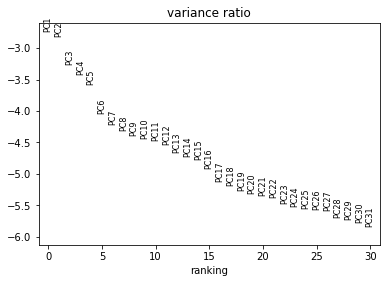

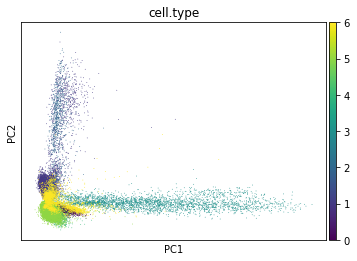

In [30]:
#Principal component analysis
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)
sc.pl.pca(adata, color='cell.type')
adata.write(fn)

In [33]:
# neighborhood graph of cells (determine optimal number of PCs here)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
# compute UMAP
sc.tl.umap(adata)
# tSNE
tsne = TSNE( n_jobs=10 )
adata.obsm['X_tsne'] = tsne.fit_transform( adata.X )
adata.write(fn)

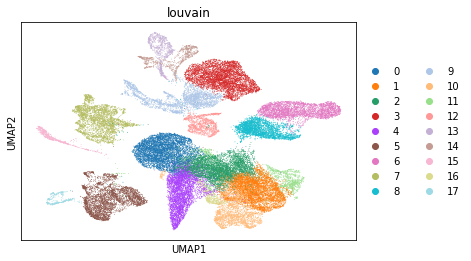

In [54]:
# cluster the neighbourhood graph
sc.tl.louvain(adata,resolution=0.4)
sc.pl.umap(adata, color=['louvain'] )

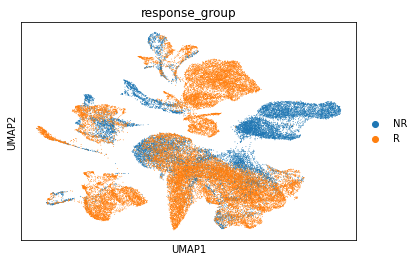

In [161]:
sc.pl.umap(adata, color=['response_group'] )

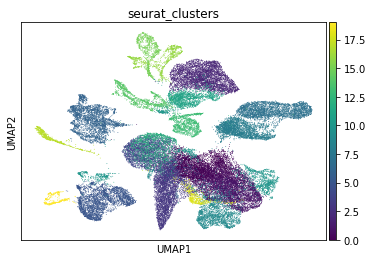

In [165]:
sc.pl.umap(adata, color=['seurat_clusters'] )

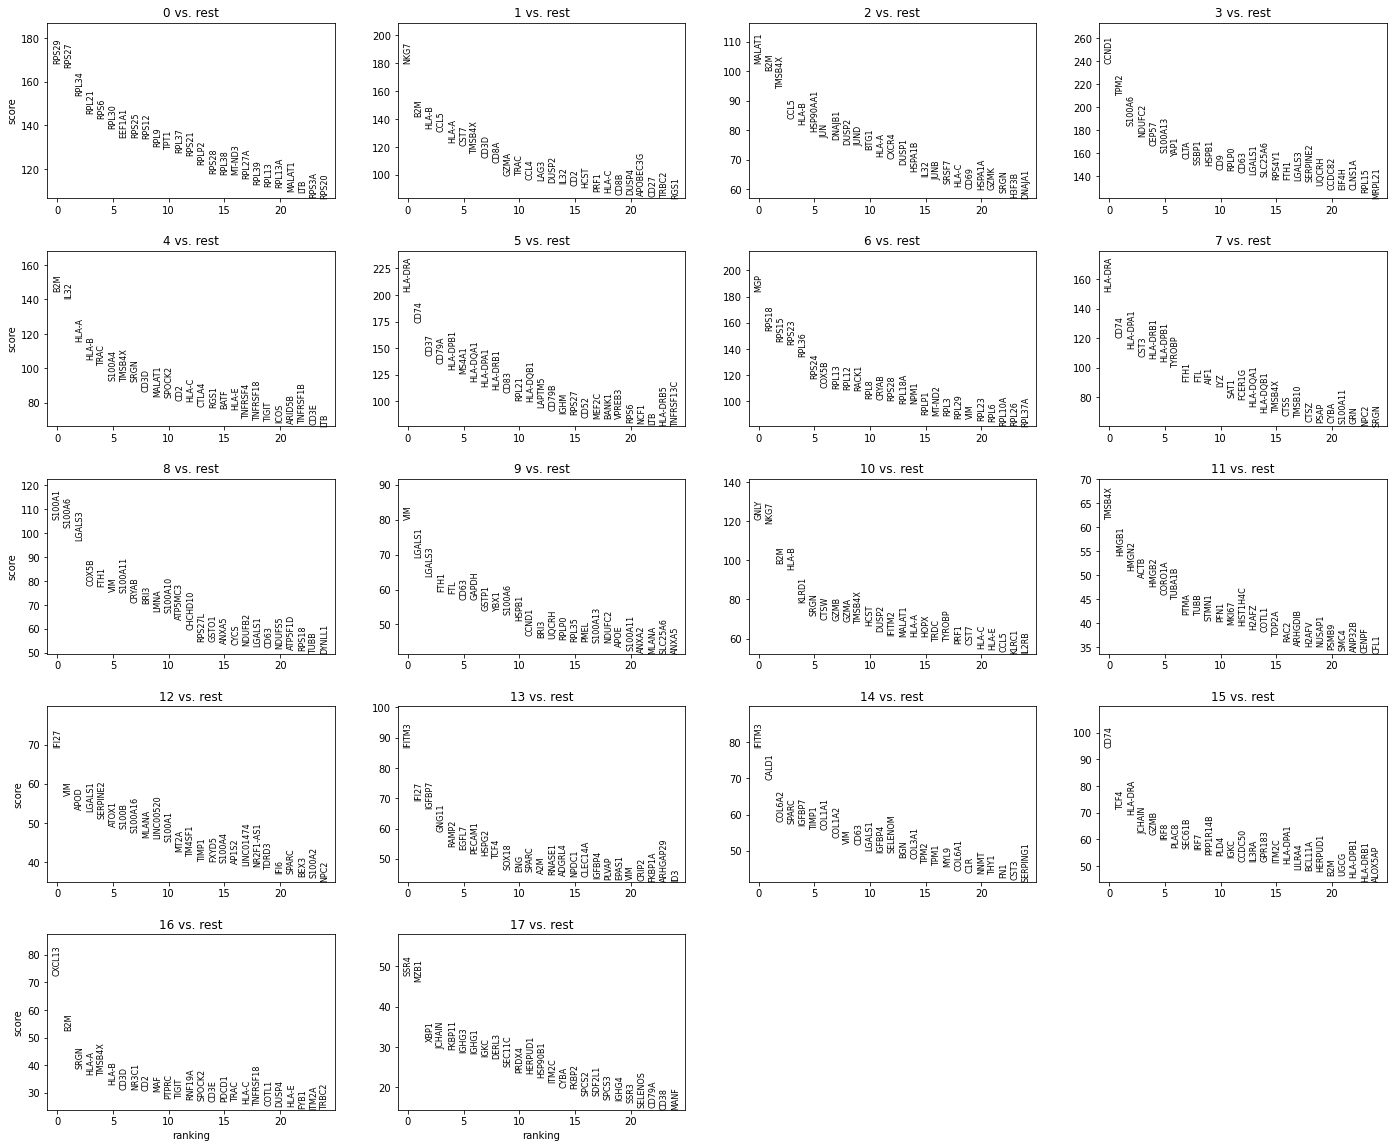

In [57]:
#Look at marker genes for found clusters
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')
# sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)
adata.write(fn)


In [65]:
#Loom file name with preprocessing done
f_loom_path_scenic = "filtered_scenic.loom"

#Create basic row and column attributes for the loom file:
row_attrs = {
    "Gene": np.array(adata.var_names) ,
}
col_attrs = {
    "CellID": np.array(adata.obs_names) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}
lp.create( f_loom_path_scenic, adata.X.transpose(), row_attrs, col_attrs)

#### Network Inference
Explores regulatory interactions between transcription factors and target genes through co-expression analysis

In [77]:
#Loads the curated list of human TFs
hgnc_tf = 'hs_hgnc_curated_tfs.txt'
tf_names = load_tf_names(hgnc_tf)

In [173]:
#Intersection in TF list and genes in dataset
len(list(set(tf_names) & set(adata.var_names)))

175

In [155]:
#Maps response based on patient ID
R = ['1009_on', '1130','1227_pre', '509_2', '509_post',]
NR = ['1224_post-Cln', '1224_post-FT', '620', '776_on', '856_A', '856_B']
response_dict = {**dict(zip(R,['R']*5)) , **dict(zip(NR, ['NR']*6))}
adata.obs['response_group'] = adata.obs['orig.ident'].apply(lambda x: response_dict[x])

#Seurat clusters 1, 5 and 7 identified as malignant (manual curation)
#Test for responders for now
malig_idx = (((adata.obs['seurat_clusters'] == 1) | 
             (adata.obs['seurat_clusters'] == 5) | 
             (adata.obs['seurat_clusters'] == 7)) &
             (adata.obs['response_group'] == 'R'))

#Creates a dataframe with the expression values
ex_matrix = pd.DataFrame(adata.X[malig_idx], 
                         index=adata.obs_names[malig_idx],
                         columns=adata.var_names)
print(np.shape(ex_matrix))
ex_matrix.head()

(6726, 3000)


,HES4,ISG15,TNFRSF18,TNFRSF4,MXRA8,VWA1,GABRD,HES5,AJAP1,ACOT7,...,MT-ND2,MT-CO1,MT-CO2,MT-ATP6,MT-CO3,MT-ND3,MT-ND4,MT-CYB,AC145212.1,AC233755.2
PT1009_ATCTCTATCGGTGTTA-1,-0.605606,-1.514939,-1.234211,-1.111129,-0.175306,-0.322216,-0.046888,-0.055609,-0.056788,-0.765106,...,-0.807111,0.760055,0.494453,-0.460395,1.260603,-0.270788,-0.774283,-0.533921,-0.023078,-0.006343
PT1009_TGCTGAATCCGACAGC-1,-0.846823,-0.730034,0.028909,-1.285880,-0.266856,-0.586974,-0.117905,-0.093080,-0.075923,-0.114168,...,-0.590090,-0.146943,0.495533,-0.002576,1.447894,-0.419777,-0.243616,-1.029905,-0.039868,-0.016185
PT1130_ATAGGCTGTGAAGCGT-1,-0.678675,-0.872825,-0.035687,-1.074837,-0.218052,-0.120307,-0.110579,-0.068286,-0.048402,-0.504529,...,-0.999405,0.230463,1.733744,0.455411,0.267384,-1.002001,0.139404,-0.846044,-0.030699,-0.014251
PT1130_ATCGCCTGTCGAATTC-1,-0.512294,-0.043074,2.774658,-1.067366,-0.138714,-0.192676,-0.009850,-0.042244,-0.054470,-0.819260,...,-0.038654,-0.366059,-0.323760,0.206548,0.218619,-0.212896,0.655313,-0.126879,-0.016791,-0.001204
PT1130_GCCATGGGTTCAGCTA-1,-0.494495,-0.318029,-0.858448,-0.891427,-0.161478,-0.397179,-0.083057,-0.043147,-0.028267,-0.315563,...,-1.651274,1.479775,-0.379180,0.070045,1.229928,-0.438742,-0.775168,-0.420223,-0.020995,-0.009486


In [156]:
#Subsamples
# samp_size = 5000
# ex_matr_samp = ex_matrix.iloc[:samp_size,:]
# print(np.shape(ex_matr_samp))
# ex_matr_samp.head()

In [157]:
#Initial phase of the pySCENIC pipeline: the single cell expression profiles are used
#to infer co-expression modules
adjancencies = grnboost2(expression_data=ex_matrix, tf_names=tf_names, verbose=True)

preparing dask client
parsing input
creating dask graph
4 partitions
computing dask graph
shutting down client and local cluster


distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing


finished


KeyboardInterrupt: 

In [ ]:
adjacencies.head()